In [110]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [133]:
data = pd.read_csv('datasets/data.csv', index_col=0)
data = data[['BBAS3', 'CSAN3']]
data = data[::-1]
data = data[:140]

In [134]:
numbers = np.arange(1, len(data)+1)
data['Dudiv'] = numbers
data['Du'] = 140 - numbers + 1

In [135]:
data

,BBAS3,CSAN3,Dudiv,Du
Data,,,,
29/06/2020,33.44,70.18,1,140
26/06/2020,31.82,68.69,2,139
25/06/2020,33.01,70.16,3,138
24/06/2020,32.22,68.79,4,137
23/06/2020,33.53,68.76,5,136
...,...,...,...,...
09/12/2019,48.62,65.86,136,5
06/12/2019,48.47,66.54,137,4
05/12/2019,48.67,65.65,138,3


In [136]:
y = data['BBAS3']
x = data[['CSAN3', 'Du']]

In [142]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print('Coef.Temp: {}'.format(model.params['Du']))
print('Coef.Ang: {}'.format(model.params['CSAN3']))
print('Coef.Linear: {}'.format(model.params['const']))
print(model.summary())

Coef.Temp: -0.1463314727157582
Coef.Ang: 0.6121081780727566
Coef.Linear: 8.173469578706111
                            OLS Regression Results                            
Dep. Variable:                  BBAS3   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1208.
Date:                Wed, 01 Jul 2020   Prob (F-statistic):           9.66e-88
Time:                        22:58:23   Log-Likelihood:                -317.90
No. Observations:                 140   AIC:                             641.8
Df Residuals:                     137   BIC:                             650.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [113]:
coef_temp = -0.1463
coef_ang = 0.612
coef_linear = 8.17

#data['resid'] = data['BBAS3']-coef_ang*data['CSAN3']-data['Du']*coef_temp-coef_linear
data['resid'] = data['BBAS3']-coef_ang*data['CSAN3']-data['Du']*coef_temp-coef_linear
data = data[::-1]
ativ = data[len(data)-140:]

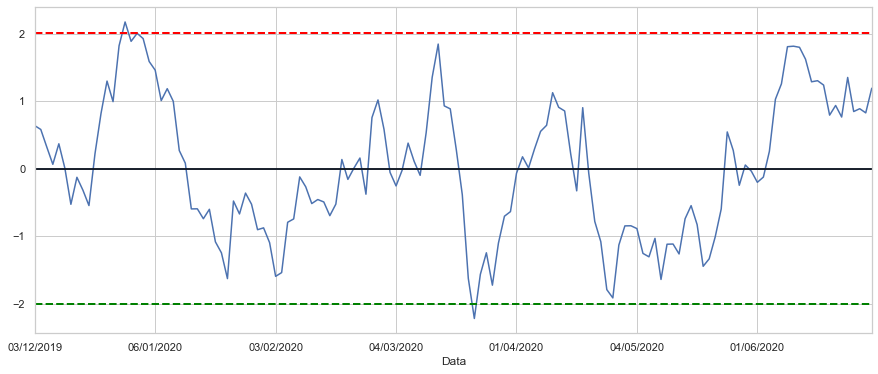

In [114]:
result = zscore(ativ.resid)
std = statistics.stdev(result)
result.plot(figsize=(15,6))
plt.axhline(result.mean())

plt.axhline(0, color='black',label='mean') # Add the mean of residual
plt.axhline(2*std, color='red', linestyle='--', linewidth=2)
plt.axhline(-2*std, color='green', linestyle='--', linewidth=2)

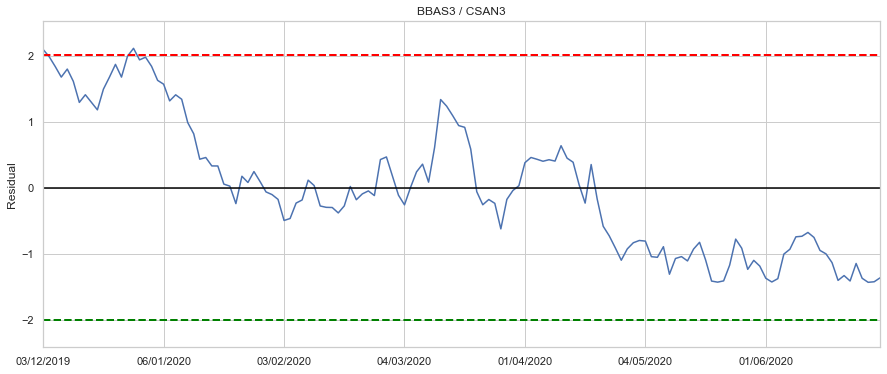

In [74]:
show(data, 'BBAS3', 'CSAN3', 140)

In [86]:
y = df['ABEV3'][::-1][:16]
x = df['AZUL4'][::-1][:16]

In [87]:
model = model_ols(y, x)
model.params

const    12.331152
AZUL4     0.070813
dtype: float64